In [1]:
import numpy as np
import pandas as pd

import Bio
from Bio import SeqIO, AlignIO
from Bio import Entrez
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import os, re, io, random, string
from Bio.Align import MultipleSeqAlignment
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

import seaborn as sns
import matplotlib.pyplot as plt

metadata = pd.read_csv("metadata.csv")

# # create column for the Bangladesh and Malaysia clades
# metadata["Clade_grouped"] = metadata["Country"].map({"Cambodia": "Malaysia", "Thailand": "Bangladesh", "India": "Bangladesh"}).fillna(metadata["Country"])

# Make FASTA files of codons and AA to plot with trees

In [3]:
aln = AlignIO.read("seq_for_analysis/G_no_stop_codons_HeV.fasta", "fasta")
AlignIO.write(aln, "seq_for_analysis/G_no_stop_codons_HeV.phy", "phylip")

1

In [2]:
meme_sig = pd.read_csv("hyphy/MEME/significance_P.csv")
sig_sites = meme_sig.loc[meme_sig["p-value"] <= 0.1].Site.values

meme_sites = meme_sig.loc[meme_sig["p-value"] <= 0.1].Site.values

# 380 was the only site with diversifying selection in FEL
meme_sites

array([ 58,  64, 228, 377, 380, 408, 421, 437, 438])

In [105]:
info_dict = dict(zip(metadata["ID"], metadata["Country"] + "/" + metadata["Host"]))
P_all = [(seq.id, str(seq.seq)) for seq in SeqIO.parse("seq_for_analysis/P_unique_HeV.fasta", "fasta")]

with open("seq_for_analysis/P_pos_codons.fasta", "w+") as file:
    
    for isolate in P_all:
        
        file.write(">" + isolate[0] + "/" + info_dict[isolate[0]] + "\n")
        
        # write only the desired codons
        seq_to_write = "".join([isolate[1][(num-1)*3:(num-1)*3+3] for num in meme_sites])
        
        file.write(seq_to_write + "\n")
        
aln = AlignIO.read("seq_for_analysis/P_pos_codons.fasta", "fasta")
AlignIO.write(aln, "seq_for_analysis/P_pos_codons.phy", "phylip")

1

In [3]:
def get_sites(lst_sites, fasta_file):
    '''
    Site list is 1-indexed, so decrement by 1 in Python searching. Sites are amino acid positions!
    '''
    seqs = [(seq_record.id, seq_record.seq) for seq_record in SeqIO.parse(fasta_file, "fasta")]
    ids, seqs = list(zip(*seqs))
    
    # translate to amino acid sequence
    aa = [Seq.translate(seq) for seq in seqs]
    
    # initialize dataframe to store the results with the sequence IDs
    df_aa = pd.DataFrame({"ID": ids})
    df_nuc = pd.DataFrame({"ID": ids})
    
    for site in lst_sites:
        df_aa[str(site)] = [seq[site-1][0] for seq in aa]
        
        last_codon = site*3
        df_nuc[str(site)] = ["".join(seq[last_codon-3:last_codon]) for seq in seqs]
        
    df_aa = df_aa.melt(id_vars="ID", var_name="Pos", value_name="AA")
    df_nuc = df_nuc.melt(id_vars="ID", var_name="Pos", value_name="Codon")
    
    df_final = df_aa.merge(df_nuc, on=["ID", "Pos"])
    return df_final.merge(metadata, on="ID")

In [4]:
P_meme_sites_aa = get_sites(sig_sites, "seq_for_analysis/P_no_stop_codons.fasta")

In [92]:
P_df = pd.DataFrame(P_all)
P_df.columns = ["ID", "Seq"]
P_df = P_df.merge(metadata, on="ID")

In [100]:
for seq in P_df.Seq.unique():
    
    single_df = P_df.query("Seq == @seq")
    if len(single_df.Host.value_counts()) > 1:
        print(seq, single_df.Host.value_counts())

ATGGATAAATTGGAACTAGTCAATGATGGCCTCAATATTATTGACTTTATTCAGAAGAACCAAAAAGAAATACAGAAGACATACGGACGATCAAGTATTCAACAACCCAGCATCAAAGATCAAACAAAAGCCTGGGAAGATTTTCTGCAGTGCACCAGTGGAGAATCTGAACAAGTTGAGGGGGGAATGTCTAAGGATGATGGAGATGTTGAAAGAAGAAACTTGGAGGATCTATCCAGTACTTCTCCCACAGATGGAACTATTGGAAAGAGAGTGTCGAACACCCGTGACTGGGCAGAAGGTTCAGATGACATACAACTGGACCCAGTGGTTACAGACGTTGTATACCATGATCATGGAGGAGAATGTACCGGATATGGATTTACTTCAAGCCCTGAGAGAGGGTGGAGTGATTACACATCAGGAGCAAACAATGGGAATGTATGTCTTGTATCTGATGCAAAGATGCTGTCCTATGCTCCCGAAATTGCAGTTTCTAAAGAAGATCGGGAAACTGATCTAGTTCATCTTGAGAATAAACTATCTACTACAGGACTGAATCCCACAGCAGTACCGTTCACTCTGAGAAACCTGTCTGATCCTGCAAAAGACTCTCCTGTGATTGCTGAACACTACTACGGACTAGGAGTTAAAGAGCAAAACGTTGGCCCTCAGACTAGCAGAAATGTCAATTTGGACAGCATCAAATTGTACACATCAGATGACGAAGAGGCAGATCAGCTTGAATTCGAAGATGAGTTTGCAGGAAGCTCAAGTGAAGTGATAGTCGGCATTTCTCCTGAAGATGAAGAGCCTTCAAGTGTTGGCGGAAAACCCAATGAATCCATTGGACGTACAATCGAAGGCCAATCAATCCGAGACAACCTTCAAGCCAAGGACAACAAATCAACAGATGTACCAGGAGCAGGACCGAAAGATTCAGCAGTGAAGGAAGAACCACCCCAGAAGAGGCTACCTATGTTAGCTGAAGAATTTGAGT

In [102]:
multi_host = P_df.query("Seq == 'ATGGATAAATTGGAACTAGTCAATGATGGCCTCAATATTATTGACTTTATTCAGAAGAACCAAAAAGAAATACAGAAGACATACGGACGATCAAGTATTCAACAACCCAGCATCAAAGATCAAACAAAAGCCTGGGAAGATTTTCTGCAGTGCACCAGTGGAGAATCTGAACAAGTTGAGGGGGGAATGTCTAAGGATGATGGAGATGTTGAAAGAAGAAACTTGGAGGATCTATCCAGTACTTCTCCCACAGATGGAACTATTGGAAAGAGAGTGTCGAACACCCGTGACTGGGCAGAAGGTTCAGATGACATACAACTGGACCCAGTGGTTACAGACGTTGTATACCATGATCATGGAGGAGAATGTACCGGATATGGATTTACTTCAAGCCCTGAGAGAGGGTGGAGTGATTACACATCAGGAGCAAACAATGGGAATGTATGTCTTGTATCTGATGCAAAGATGCTGTCCTATGCTCCCGAAATTGCAGTTTCTAAAGAAGATCGGGAAACTGATCTAGTTCATCTTGAGAATAAACTATCTACTACAGGACTGAATCCCACAGCAGTACCGTTCACTCTGAGAAACCTGTCTGATCCTGCAAAAGACTCTCCTGTGATTGCTGAACACTACTACGGACTAGGAGTTAAAGAGCAAAACGTTGGCCCTCAGACTAGCAGAAATGTCAATTTGGACAGCATCAAATTGTACACATCAGATGACGAAGAGGCAGATCAGCTTGAATTCGAAGATGAGTTTGCAGGAAGCTCAAGTGAAGTGATAGTCGGCATTTCTCCTGAAGATGAAGAGCCTTCAAGTGTTGGCGGAAAACCCAATGAATCCATTGGACGTACAATCGAAGGCCAATCAATCCGAGACAACCTTCAAGCCAAGGACAACAAATCAACAGATGTACCAGGAGCAGGACCGAAAGATTCAGCAGTGAAGGAAGAACCACCCCAGAAGAGGCTACCTATGTTAGCTGAAGAATTTGAGTGCTCTGGATCGGAAGACCCAATCATTCGGGAGCTGCTGAAGGAGAACTCACTCATAAATTGTCAGCAAGGGAAAGATGCTCAGCCTCCATATCATTGGAGCATCGAGAGGTCAATAAGCCCGGATAAAACTGAGATCGTCAACGGTGCTGTGCAAACTGCTGACAGGCAAAGACCAGGAACTCCGATGCCAAAGTCCCGAGGTATTCCCATTAAAAAGGGCACAGACGCGAAATATCCATCTGCTGGGACGGAAAACGTGCCTGGGTCGAAGAGTGGTGCAACCCGGCATGTTCGAGGATCACCCCCCTACCAAGAAGGCAAGAGTGTCAATGCGGAGAATGTCCAACTGAATGCTTCCACTGCGGTTAAGGAAACTGATAAGTCAGAAGTAAACCCCGTAGACGACAACGACTCACTTGATGATAAATACATCATGCCTTCAGATGATTTCTCAAACACTTTCTTCCCGCACGACACTGATCGCTTGAATTATCACGCAGATCATTTAGGTGATTATGACCTTGAAACCCTGTGTGAAGAGTCGGTTCTAATGGGAGTGATCAACTCTATAAAATTAATTAATCTGGATATGCGCTTAAATCACATTGAAGAACAAGTTAAAGAGATCCCAAAGATCATCAATAAGCTTGAGTCCATTGACAGAGTTCTGGCCAAGACTAACACCGCACTCTCAACCATTGAAGGACACCTGGTTTCCATGATGATAATGATACCAGGGAAAGGGAAAGGAGAAAGAAAGGGGAAAAATAATCCTGAGCTTAAACCAGTGATAGGAAGAGACATTCTAGAGCAGCAATCTCTTTTTTCTTTTGACAATGTCAAGAATTTCAGAGATGGATCGTTGACAAACGAACCGTATGGGGCAGCTGTACAGTTGAGAGAAGATCTTATTCTTCCTGAACTTAATTTTGAGGAGACAAATGCATCTCAATTTGTTCCTATGGCAGATGATTCATCCAGAGATGTTATCAAGACATTGATAAGGACTCACATTAAAGATAGAGAGTTGAGATCAGAACTGATTGGTTACCTGAATAAAGCGGAAAATGATGAGGAAATTCAGGAGATAGCGAACACTGTCAATGACATCATTGACGGTAATATTTGA'")

In [104]:
multi_host.ID.values

array(['AF212302', 'AJ564621', 'AJ564622', 'AJ564623', 'AY029767',
       'AY029768', 'KY425646', 'KY425655', 'MK673558', 'MK673560',
       'MK673561', 'MK673562', 'MK673563', 'NC_002728'], dtype=object)

In [8]:
P_meme_summary_df = P_meme_sites_aa.groupby(["Pos", "Clade_grouped", "Codon"])[["AA"]].count().reset_index()
P_meme_summary_df.columns = ["Pos", "Clade", "Codon", "Count"]
P_meme_summary_df["Pos"] = P_meme_summary_df["Pos"].astype(int)
P_meme_summary_df.sort_values(["Pos", "Clade"]).reset_index(drop=True)

,Pos,Clade,Codon,Count
0,58,Bangladesh,AAA,1
1,58,Bangladesh,CAA,37
2,58,Malaysia,CAA,6
3,64,Bangladesh,CCT,11
4,64,Bangladesh,TCT,27
5,64,Malaysia,TCT,6
6,228,Bangladesh,AAA,11
7,228,Bangladesh,AGA,27
8,228,Malaysia,AGA,6
9,377,Bangladesh,ACT,36


In [112]:
# find the sites that are evolving
sig_branches = meme_branches.query("Site in @sig_sites")
sig_branches = sig_branches.merge(metadata, left_on="Branch", right_on="ID")
del sig_branches["ID"]

In [114]:
sig_branches.groupby(["Site"]).Branch.value_counts()

Site  Branch  
58    AF212302    1
      AF376747    1
      AJ627196    1
      AY988601    1
      FJ513078    1
                 ..
438   MN549405    1
      MN549406    1
      MN549409    1
      MN549410    1
      MW535746    1
Name: Branch, Length: 396, dtype: int64

In [117]:
sig_branches

,Site,Partition,Branch,EBF,Clade,Date,Country,Host,G,P,Clade_grouped
0,228,0,AF212302,1.00,NaN,1999-12-08,Malaysia,human,1,1,Malaysia
1,377,0,AF212302,1.00,NaN,1999-12-08,Malaysia,human,1,1,Malaysia
2,380,0,AF212302,1.00,NaN,1999-12-08,Malaysia,human,1,1,Malaysia
3,408,0,AF212302,1.00,NaN,1999-12-08,Malaysia,human,1,1,Malaysia
4,421,0,AF212302,1.00,NaN,1999-12-08,Malaysia,human,1,1,Malaysia
...,...,...,...,...,...,...,...,...,...,...,...
391,421,0,MW535746,0.82,NaN,2017-05-21,Thailand,bat,1,1,Bangladesh
392,437,0,MW535746,0.73,NaN,2017-05-21,Thailand,bat,1,1,Bangladesh
393,438,0,MW535746,0.50,NaN,2017-05-21,Thailand,bat,1,1,Bangladesh
394,58,0,MW535746,0.04,NaN,2017-05-21,Thailand,bat,1,1,Bangladesh


In [116]:
pd.DataFrame(sig_branches.groupby(["Site"]).Clade_grouped.value_counts())

Clade_grouped
Site Clade_grouped               
58   Bangladesh                38
     Malaysia                   6
64   Bangladesh                38
     Malaysia                   6
228  Bangladesh                38
     Malaysia                   6
377  Bangladesh                38
     Malaysia                   6
380  Bangladesh                38
     Malaysia                   6
408  Bangladesh                38
     Malaysia                   6
421  Bangladesh                38
     Malaysia                   6
437  Bangladesh                38
     Malaysia                   6
438  Bangladesh                38
     Malaysia                   6

In [ ]:


def make_pos_selection_summaries(summary_df):
    
    aa_summary = pd.DataFrame(summary_df.groupby(["Country", "Pos"])["AA"].value_counts()).rename(columns={"AA": "Count"}).reset_index()
    #aa_summary = aa_summary.query("(Country != 'Cambodia') & (Country != 'Thailand')")
    
    codon_summary = pd.DataFrame(summary_df.groupby(["Country", "Pos"])["Codon"].value_counts()).rename(columns={"Codon": "Count"}).reset_index()
    #codon_summary = codon_summary.query("(Country != 'Cambodia') & (Country != 'Thailand')")
    
    # aa_summary = pd.DataFrame(P_summary.groupby(["Host", "Pos"])["AA"].value_counts()).rename(columns={"AA": "Count"}).reset_index()
    # aa_summary = P_aa_summary.query("(Host != 'dog')")
    
    return aa_summary.merge(codon_summary)

In [12]:
sig_sites

array([ 58,  64, 228, 377, 380, 408, 421, 437, 438])

In [26]:
meme_sig_isolates = meme_branches.query("Site in @sig_sites").merge(metadata, left_on="Branch", right_on="ID")
del meme_sig_isolates["ID"]

In [30]:
meme_sig_isolates.drop_duplicates("Branch").Country.value_counts()

Bangladesh    27
India         10
Malaysia       5
Cambodia       1
Thailand       1
Name: Country, dtype: int64

In [29]:
meme_sig_isolates

,Site,Partition,Branch,EBF,Clade,Date,Country,Host,G,P
0,228,0,AF212302,1.00,NaN,1999-12-08,Malaysia,human,1,1
1,377,0,AF212302,1.00,NaN,1999-12-08,Malaysia,human,1,1
2,380,0,AF212302,1.00,NaN,1999-12-08,Malaysia,human,1,1
3,408,0,AF212302,1.00,NaN,1999-12-08,Malaysia,human,1,1
4,421,0,AF212302,1.00,NaN,1999-12-08,Malaysia,human,1,1
...,...,...,...,...,...,...,...,...,...,...
391,421,0,MW535746,0.82,NaN,2017-05-21,Thailand,bat,1,1
392,437,0,MW535746,0.73,NaN,2017-05-21,Thailand,bat,1,1
393,438,0,MW535746,0.50,NaN,2017-05-21,Thailand,bat,1,1
394,58,0,MW535746,0.04,NaN,2017-05-21,Thailand,bat,1,1


# PAML

Copied all `.ctl` files from the tar file for Linux/Mac <a href="http://abacus.gene.ucl.ac.uk/software/#downloads-and-installation-2" target="_blank">here</a>.

# HyPhy

## Data input format (easiest of the options):

Two separate files with the alignment and phylogeny each. 

Most standard alignment formats are accepted (FASTA, phylip, etc.), and the phylogeny should be Newick-formatted.

Launch with `hyphy -i`

Tutorial: http://hyphy.org/tutorials/CL-prompt-tutorial/

# Methods

Good explanations: https://stevenweaver.github.io/hyphy-site/methods/selection-methods

## BUSTED

BUSTED (Branch-Site Unrestricted Statistical Test for Episodic Diversification) provides a gene-wide (not site-specific) test for positive selection by asking whether a gene has experienced positive selection at at least one site on at least one branch.

<ul>
    <li>Can specify which branches to test or do all of them.</li>
    <li> It is gene-wide, not site-specific, so probably not desired for our purposes?</li>
</ul>


## FEL and SLAC

Infer dN and dS substitutions rates on a per-site basis. Assume that selection pressure for each site is constant along the entire phylogeny. This is probably not true in this case because the Nipah virus sequences come from different organisms with different immune behavior. <b>How do we account for this without a temporal analysis?</b>

SLAC uses maximum-likelihood and counting approaches. FEL is a fixed effects model.  

# Fasta files can not have stop codons in them, so generate new files for them

Located at `seq_for_analysis/G_no_stop_codons.fasta` and `seq_for_analysis/P_no_stop_codons.fasta`

Isolate MK575063 was manually removed from `seq_for_analysis/P_no_stop_codons.fasta` becuase it contains a premature stop codon, which causes errors in HyPhy analyses.

# Also convert sequences to PHYLIP format for PhyML

In [6]:
def remove_stop_codons_and_ambig_nuc(og_fasta, new_fasta, drop_premature=None):
    
    seqs = [(seq_record.id, str(seq_record.seq)) for seq_record in SeqIO.parse(og_fasta, "fasta")]
    seq_df = pd.DataFrame(seqs).rename(columns={0: "ID", 1:"Seq"})
    
#     for i, row in seqs_df.iterrows():
#         if count_ambig_nuc(row["Seq"]) / len(row["Seq"]) >= 0.01:
#             seqs_df.loc[i, "Ambig"] = 1

#     seqs_df["Ambig"] = seqs_df["Ambig"].fillna(0).astype(int)
#     return seqs_df.query("Ambig == 0")

    # remove all sequences containing an N
    seq_df = seq_df.loc[~seq_df.Seq.str.contains("N")]
    
    if drop_premature is not None:
        seq_df = seq_df.loc[~seq_df.ID.isin(drop_premature)]
        
    with open(new_fasta, "w+") as file:
        for _, row in seq_df.iterrows():
            file.write(">" + row["ID"] + "\n")
            file.write(row["Seq"][:-3] + "\n")
            
    print(seq_df.shape)
            
remove_stop_codons_and_ambig_nuc("seq_for_analysis/G_dedup.fasta", "seq_for_analysis/G_no_stop_codons.fasta")
remove_stop_codons_and_ambig_nuc("seq_for_analysis/P_dedup.fasta", "seq_for_analysis/P_no_stop_codons.fasta", ["MK575063"])

# convert sequences to PHYLIP format for PhyML
aln_G = AlignIO.parse('seq_for_analysis/G_no_stop_codons.fasta', "fasta")
AlignIO.write(aln_G, 'seq_for_analysis/G_no_stop_codons.phy', 'phylip')

aln_P = AlignIO.parse('seq_for_analysis/P_no_stop_codons.fasta', "fasta")
AlignIO.write(aln_P, 'seq_for_analysis/P_no_stop_codons.phy', 'phylip')

(37, 2)
(44, 2)


1

In [12]:
def seq_distance(seq1, seq2):
    
    assert len(seq1) == len(seq2)
    return len(seq1) - int(pairwise2.align.globalxx(seq1, seq2, score_only=True))

In [13]:
def get_distance_matrix(og_file, dist_file):
    
    seqs = [(seq_record.id, str(seq_record.seq)) for seq_record in SeqIO.parse(og_file, "fasta")]
    ids_only = list(zip(*seqs))[0]
    seqs_only = list(zip(*seqs))[1]
    
    dist_mat = np.zeros((len(seqs), len(seqs)))

    for i in range(len(seqs_only)):
        distances = [seq_distance(seqs_only[i], seqs_only[j]) for j in range(len(seqs_only))]
        dist_mat[i, :] = distances

    dist_df = pd.DataFrame(dist_mat)
    dist_df.columns = ids_only
    dist_df.index = ids_only
    dist_df = dist_df.astype(int)
    
    print(dist_df.shape)
    dist_df.to_csv(dist_file)

In [14]:
get_distance_matrix("seq_for_analysis/G_no_stop_codons.fasta", 
                    "seq_for_analysis/G_no_stop_codons_dist_mat.csv")

(40, 40)


In [15]:
P_dist_df = pd.read_csv("seq_for_analysis/P_no_stop_codons_dist_mat.csv", index_col=0)
G_dist_df = pd.read_csv("seq_for_analysis/G_no_stop_codons_dist_mat.csv", index_col=0)

In [18]:
G_dist_df[["MK575060", "MK575063"]].sort_values("MK575060")

,MK575060,MK575063
MK575060,0,1
MK575069,1,2
MK575063,1,0
MK673589,2,3
JN808864,3,4
AY988601,4,5
MK673567,7,8
MK673566,7,8
MK673571,7,8
MK673584,7,8


>AF212302
ATGGATAAATTGGAACTAGTCAATGATGGCCTCAATATTATTGACTTTATTCAGAAGAACCAAAAAGAAATACAGAAGACATACGGACGATCAAGTATTCAACAACCCAGCATCAAAGATCAAACAAAAGCCTGGGAAGATTTTCTGCAGTGCACCAGTGGAGAATCTGAACAAGTTGAGGGGGGAATGTCTAAGGATGATGGAGATGTTGAAAGAAGAAACTTGGAGGATCTATCCAGTACTTCTCCCACAGATGGAACTATTGGAAAGAGAGTGTCGAACACCCGTGACTGGGCAGAAGGTTCAGATGACATACAACTGGACCCAGTGGTTACAGACGTTGTATACCATGATCATGGAGGAGAATGTACCGGATATGGATTTACTTCAAGCCCTGAGAGAGGGTGGAGTGATTACACATCAGGAGCAAACAATGGGAATGTATGTCTTGTATCTGATGCAAAGATGCTGTCCTATGCTCCCGAAATTGCAGTTTCTAAAGAAGATCGGGAAACTGATCTAGTTCATCTTGAGAATAAACTATCTACTACAGGACTGAATCCCACAGCAGTACCGTTCACTCTGAGAAACCTGTCTGATCCTGCAAAAGACTCTCCTGTGATTGCTGAACACTACTACGGACTAGGAGTTAAAGAGCAAAACGTTGGCCCTCAGACTAGCAGAAATGTCAATTTGGACAGCATCAAATTGTACACATCAGATGACGAAGAGGCAGATCAGCTTGAATTCGAAGATGAGTTTGCAGGAAGCTCAAGTGAAGTGATAGTCGGCATTTCTCCTGAAGATGAAGAGCCTTCAAGTGTTGGCGGAAAACCCAATGAATCCATTGGACGTACAATCGAAGGCCAATCAATCCGAGACAACCTTCAAGCCAAGGACAACAAATCAACAGATGTACCAGGAGCAGGACCGAAAGATTCAGCAGTGAAGGAAGAACCACCCCAGAAGAGGCTACCTATGTTAGCTGAAGAATTTGAGTGCTCTGGATCGGAAGACCCAATCATTCGGGAGCTGCTGAAGGAGAACTCACTCATAAATTGTCAGCAAGGGAAAGATGCTCAGCCTCCATATCATTGGAGCATCGAGAGGTCAATAAGCCCGGATAAAACTGAGATCGTCAACGGTGCTGTGCAAACTGCTGACAGGCAAAGACCAGGAACTCCGATGCCAAAGTCCCGAGGTATTCCCATTAAAAAGGGCACAGACGCGAAATATCCATCTGCTGGGACGGAAAACGTGCCTGGGTCGAAGAGTGGTGCAACCCGGCATGTTCGAGGATCACCCCCCTACCAAGAAGGCAAGAGTGTCAATGCGGAGAATGTCCAACTGAATGCTTCCACTGCGGTTAAGGAAACTGATAAGTCAGAAGTAAACCCCGTAGACGACAACGACTCACTTGATGATAAATACATCATGCCTTCAGATGATTTCTCAAACACTTTCTTCCCGCACGACACTGATCGCTTGAATTATCACGCAGATCATTTAGGTGATTATGACCTTGAAACCCTGTGTGAAGAGTCGGTTCTAATGGGAGTGATCAACTCTATAAAATTAATTAATCTGGATATGCGCTTAAATCACATTGAAGAACAAGTTAAAGAGATCCCAAAGATCATCAATAAGCTTGAGTCCATTGACAGAGTTCTGGCCAAGACTAACACCGCACTCTCAACCATTGAAGGACACCTGGTTTCCATGATGATAATGATACCAGGGAAAGGGAAAGGAGAAAGAAAGGGGAAAAATAATCCTGAGCTTAAACCAGTGATAGGAAGAGACATTCTAGAGCAGCAATCTCTTTTTTCTTTTGACAATGTCAAGAATTTCAGAGATGGATCGTTGACAAACGAACCGTATGGGGCAGCTGTACAGTTGAGAGAAGATCTTATTCTTCCTGAACTTAATTTTGAGGAGACAAATGCATCTCAATTTGTTCCTATGGCAGATGATTCATCCAGAGATGTTATCAAGACATTGATAAGGACTCACATTAAAGATAGAGAGTTGAGATCAGAACTGATTGGTTACCTGAATAAAGCGGAAAATGATGAGGAAATTCAGGAGATAGCGAACACTGTCAATGACATCATTGACGGTAATATT


In [19]:
P_dist_df[["MK673559", "AF212302"]].sort_values("MK673559")

,MK673559,AF212302
MK673559,0,1
AF212302,1,0
AF376747,2,1
AJ627196,6,5
FN869553,46,45
MK801755,55,54
MK673568,163,162
AY988601,164,163
MK673572,164,163
MK673571,165,164


## More metadata: clade (country), organism, date, etc. to use FEL-Contrast

In [4]:
# supplemental table from the Whitmer et al paper with metadata
new_metadata = pd.read_excel("sequences/Whitmer_SuppTable_1_V8.xlsx", header=3).iloc[:, 1:]

metadata_all = pd.read_csv("metadata_all.csv")

In [5]:
def get_ncbi_accessions(id_list):
    
    Entrez.email='skulkarni@g.harvard.edu'

    # search Genbank, returns accession numbers
    handle=Entrez.esearch(db='nucleotide', retmax=1000, term=",".join(id_list), idtype="acc") 
    record = Entrez.read(handle)
    
    handle.close()
    fetch = Entrez.efetch(db='nucleotide', id=",".join(record['IdList']), rettype='gb', retmode='text')
    gb=fetch.read()
    
    # the first one is an empty string because it's what comes before the first locus
    found_seq = list(gb.split("LOCUS"))[1:]
    print(f"Found {len(found_seq)} out of {len(id_list)} NCBI accessions!")
    
    # remove the sequences becuase they make the strings unnecessarily long
    found_seq = [isolate.split("/gene")[0] for isolate in found_seq]
    
    return found_seq

In [6]:
countries_dict = dict(zip(['India', 'Kerala', 'Malaysia', 'Perak', 'Bangladesh', 'Singapore', 'Thailand', 'Cambodia', 'Kuala Lumpur'], 
                          ['India', 'India', 'Malaysia', 'Malaysia', 'Bangladesh', 'Singapore', 'Thailand', 'Cambodia', 'Malaysia']))

def extract_metadata(fasta_file, metadata_df):
    
    acc_ids = [seq_record.id for seq_record in SeqIO.parse(fasta_file, "fasta")]
    
    ncbi_info = get_ncbi_accessions(acc_ids)
    
    metadata = metadata_df.loc[metadata_df[" Accession Number:"].isin(acc_ids)][[" Accession Number:", 'Clade', 'Collection Date', 'Location, Country', "Original organism"]]
    metadata.rename(columns={metadata.columns[0]: "ID", 'Collection Date': 'Date', 'Location, Country': 'Country', "Original organism": "Host"}, inplace=True)
    
    # merge with the accession IDs to get a full metadata datafraem
    metadata = metadata.merge(pd.DataFrame(acc_ids).rename(columns={0:"ID"}), 
                              how="outer").sort_values("ID").reset_index(drop=True)
        
    for i, row in metadata.iterrows():

        # clean so that every word is separated by a single whitespace, make lowercase, then split to get a list
        cleaned_info = re.sub('\s+',' ', ncbi_info[i]).lower().split(" ")

        if pd.isnull(row["Country"]):

            # get the country by iterating through the list of countries
            for country in list(countries_dict.keys()):
                if country in ncbi_info[i]:
                    metadata.loc[i, "Country"] = countries_dict[country]
                    break

        if pd.isnull(row["Date"]):
            
            found_date = False

            for string in cleaned_info:
                if "/collection_date=" in string:
                    metadata.loc[i, "Date"] = string.replace("/collection_date=", "").strip('""')
                    found_date = True
                    break
                if not found_date:            
                    # get the date by looking for the journal submission date
                    submitted_index = cleaned_info.index("submitted")
                    metadata.loc[i, "Date"] = cleaned_info[submitted_index+1].strip("()")

        if pd.isnull(row["Host"]):

            if "pteropus" in ncbi_info[i].lower():
                metadata.loc[i, "Host"] = "bat"
            elif "pig" in ncbi_info[i].lower() or "swine" in ncbi_info[i].lower():
                metadata.loc[i, "Host"] = "swine"
            elif "clinical" in ncbi_info[i].lower() or "homo sapiens" in ncbi_info[i].lower():
                metadata.loc[i, "Host"] = "human"

    # this whole genome is weird. Reference: https://www.sciencedirect.com/science/article/pii/S0042682201910268
    # 1999, so Malaysia, and text says it was isolated from human brain tissue.
    metadata.loc[metadata.ID == "AF212302", "Country"] = "Malaysia"
    metadata.loc[metadata.ID == "AF212302", "Host"] = "human"
    
    # also weird whole genome, but don't know the host source
    metadata.loc[metadata.ID == "NC_002728", "Country"] = "Malaysia"
    metadata.loc[metadata.ID == "NC_002728", "Date"] = "1999"
    
    # for completeness and standardization, convert them all to strings
    metadata[['Date', 'Country', "Host"]] = metadata[['Date', 'Country', "Host"]].astype(str)
    
    # then convert the date column to a datetime object
    metadata["Date"] = pd.to_datetime(metadata["Date"])
    
    # check that there are no more NaNs in the columns we just imputed
    assert sum(pd.isnull(metadata['Date'])) == 0
    assert sum(pd.isnull(metadata['Country'])) == 0
    assert sum(pd.isnull(metadata['Host'])) == 0
    
    return metadata

In [22]:
G_metadata = extract_metadata("sequences/PG/G_seqs.fasta", new_metadata)
P_metadata = extract_metadata("sequences/PG/P_seqs.fasta", new_metadata)

Found 84 out of 84 NCBI accessions!
Found 81 out of 81 NCBI accessions!


# Look at sites under positive selection in the phosphoprotein: 285, 380, 421

## Enrichment of the different amino acids across metadata?

# See if the alleles associate with clades, countries, organisms, etc.

## alpha > beta = negative
## alpha < beta = positive

Use posterior probability of 0.9 as the threshold

In [1]:
def plot_neg_selection(fName):
    
    data = pd.read_csv(fName)
    data.columns = ["Site", "Partitions", "a", "b", "b-a", "P(a>b)", "P(a<b)", "Bayes_Factor(a<b)"]
    
    # boolean variables for significant
    data["sig_negative"] = (data["P(a>b)"] >= 0.9)
    data["sig_positive"] = (data["P(a<b)"] >= 0.9)

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.scatterplot(data=data, x="Site", y="P(a>b)", hue="sig_negative", ax=ax)
    sns.despine()

    ax.set_title("Sites of Negative Selection in the NiV Phosphoprotein", fontsize=18, pad=30)
    plt.xlabel("AA Position", fontsize=14)
    plt.ylabel("Posterior Protability", fontsize=14)
    plt.legend(title="P ≥ 0.9", title_fontsize=14, fontsize=12)
    plt.savefig("hyphy/FUBAR/P_neg.png", dpi=250)
    #plt.show()

In [4]:
df = pd.read_csv("hyphy/FUBAR/20220622_P_bgd.csv")

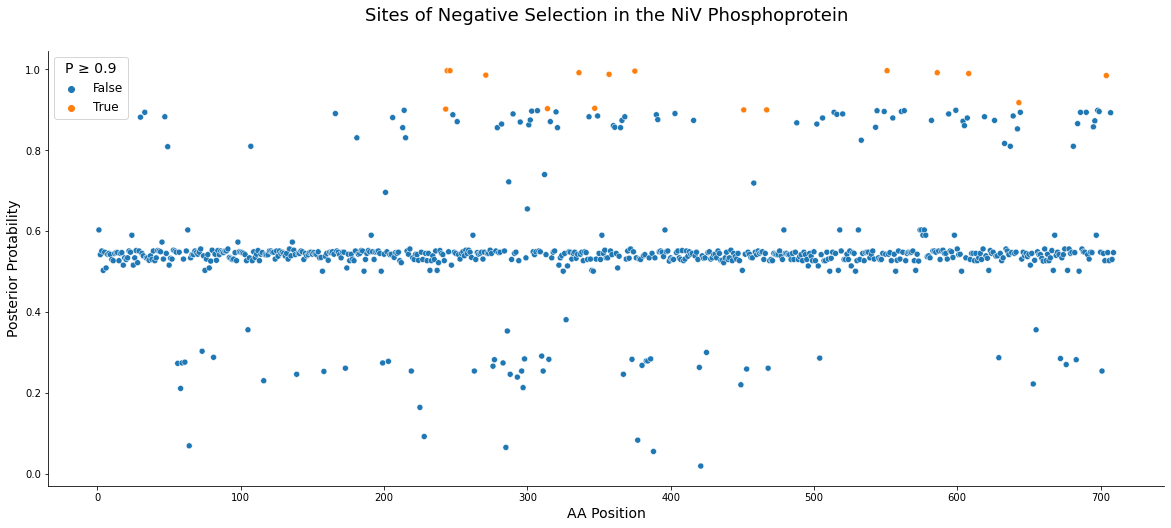

In [5]:
plot_neg_selection("hyphy/FUBAR/20220622_P_bgd.csv")

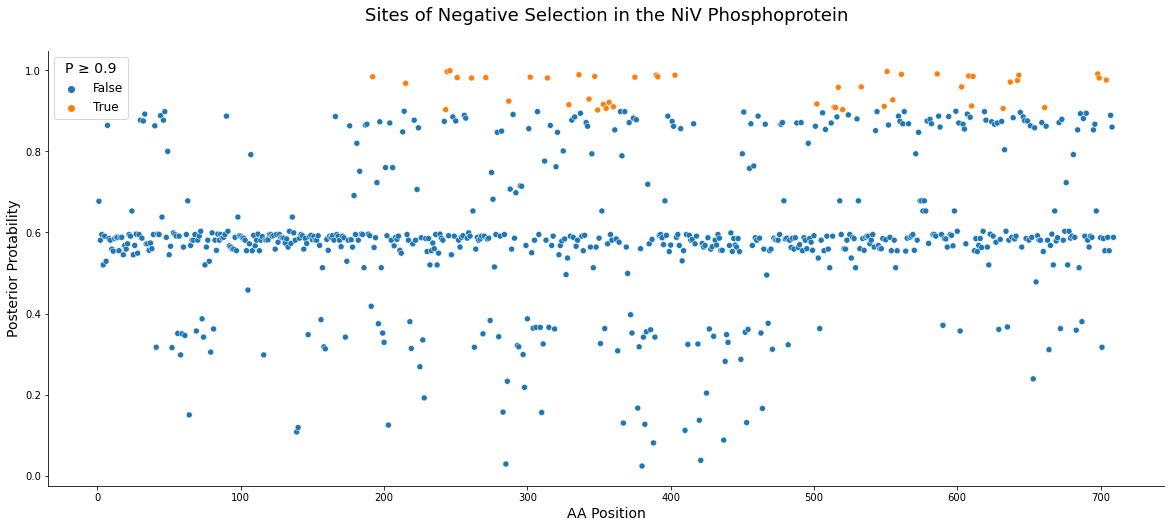

In [12]:
plot_neg_selection("hyphy/FUBAR/P_sites.csv")

560-592 = L protein binding

# STAT1 binding site???

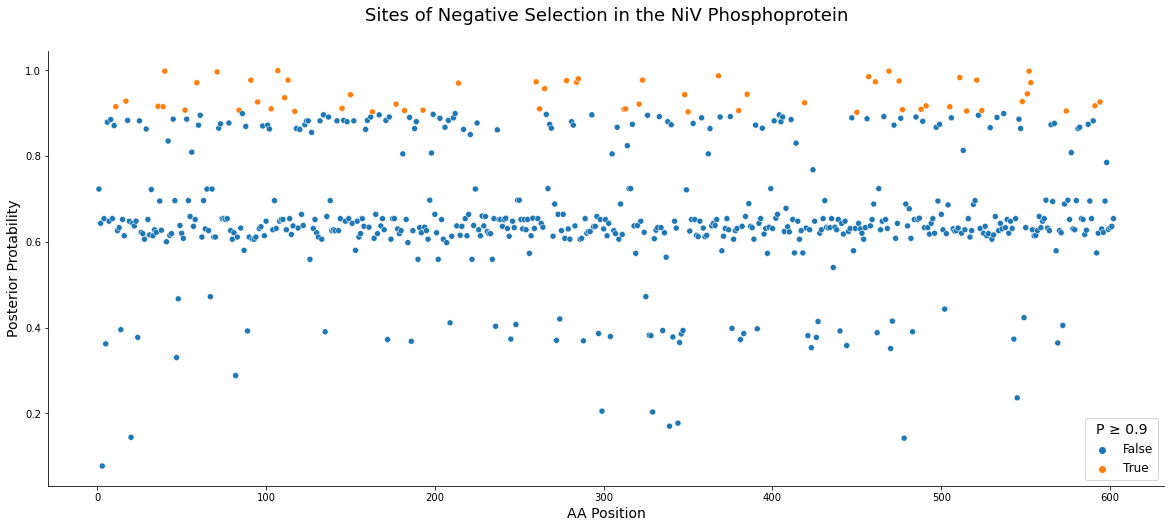

In [13]:
plot_neg_selection("hyphy/FUBAR/G_sites.csv")